<a href="https://colab.research.google.com/github/qununc/UFR/blob/main/no2_time_series/Ex_frm_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> **МФИН211 Литвинов А. А.**

---

# Задание 1. Введение в анализ временных рядов




**Цель задания:**
1. Получить  навыки работы с финансовыми временными рядами
2. Провести проверку временного ряда на стационарность 
3. Построить модель ARIMA-GARCH
4. Исследовать модель CAPM

## 1.Загрузка библиотек

In [2]:
!pip install arch yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import statsmodels.tsa as tsa # анализ временных рядов
import statsmodels.graphics.tsaplots as tsaplots # визуализация параметров временных рядов
import statsmodels.formula.api as smf # регрессионная модель
import statsmodels.stats.outliers_influence  # регрессионные тесты
import statsmodels.stats.api as test # регрессионные тесты
import statsmodels.stats.diagnostic as diagnostic # регрессионные тесты
import warnings # управлением выводом предупреждений 
warnings.filterwarnings('ignore')

In [4]:
from arch import arch_model
from arch.univariate import ConstantMean,ZeroMean,ARX,GARCH,Normal

In [5]:
warnings.filterwarnings('ignore') 

In [6]:
import matplotlib.pyplot as plt # графическая библиотека matplotlib
%matplotlib inline
import seaborn # графическая библиотека seaborn
seaborn.set_style('darkgrid')

In [7]:
seaborn.mpl.rcParams['figure.figsize'] = (10.0, 6.0) # параметры графиков
seaborn.mpl.rcParams['savefig.dpi'] = 90
seaborn.mpl.rcParams['font.family'] = 'serif'
seaborn.mpl.rcParams['font.size'] = 14

## 2.Исследование временного ряда

Для моделирования временного ряда используется подход Бокса-Дженкенса, состоящий из следующих основных этапов:
1. Проверка стационарности ряда временного ряда
2. Приведение временного ряда к стационарному виду  (взятие первых и т.д. разностей)
3. Построение модели ARIMA
4. Проверка остатков модели ARIMA на отсутствие автокорреляции
5. Проверка отсутствия автокорреляции в отношении квадратов остатков модели ARIMA
6. Построение модели GARCH

In [ ]:
msft=pd.read_csv('https://raw.githubusercontent.com/qununc/UFR/main/no2_time_series/MSFT.csv')
### загрузка данных динамики акций Microsoft

In [ ]:
msft.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-09,38.560001,38.869999,38.369999,38.709999,34.326134,30286000
1,2013-12-10,38.610001,38.900002,38.020000,38.110001,33.794098,37828600
2,2013-12-11,38.060001,38.299999,37.389999,37.610001,33.350716,39853400
3,2013-12-12,37.639999,37.639999,37.180000,37.220001,33.004879,36012800
4,2013-12-13,37.419998,37.450001,36.619999,36.689999,32.534901,40066100


In [ ]:
msft.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [ ]:
msft['Date']=pd.to_datetime(msft['Date'],format='%Y-%m-%d')
# преобразование поля в формат даты

In [ ]:
msft.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

Переход от цен к логарифмическим доходностям

$ln(\frac{p_{i+1}}{p_{i}})=ln(p_{i+1})-ln(p_i)$ 

In [ ]:
msft['Log_ret_MSFT']=np.log(msft['Adj Close'])-np.log(msft['Adj Close'].shift(1))
# расчет логарифмической доходности

In [ ]:
msft.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Log_ret_MSFT
0,2013-12-09,38.560001,38.869999,38.369999,38.709999,34.326134,30286000,NaN
1,2013-12-10,38.610001,38.900002,38.020000,38.110001,33.794098,37828600,-0.015621
2,2013-12-11,38.060001,38.299999,37.389999,37.610001,33.350716,39853400,-0.013207
3,2013-12-12,37.639999,37.639999,37.180000,37.220001,33.004879,36012800,-0.010424
4,2013-12-13,37.419998,37.450001,36.619999,36.689999,32.534901,40066100,-0.014342


In [ ]:
msft.drop([0],axis=0,inplace=True)
# удаление первого наблюдения nan

In [ ]:
msft['Log_ret_MSFT'].describe()
#основные характеристики динамического ряда логарифмической доходности

count    1258.000000
mean        0.000887
std         0.014298
min        -0.097099
25%        -0.005974
50%         0.000610
75%         0.007774
max         0.099413
Name: Log_ret_MSFT, dtype: float64

In [ ]:
np.var(msft['Log_ret_MSFT'])
# дисперсия ряда                                                             

0.0002042766448326039

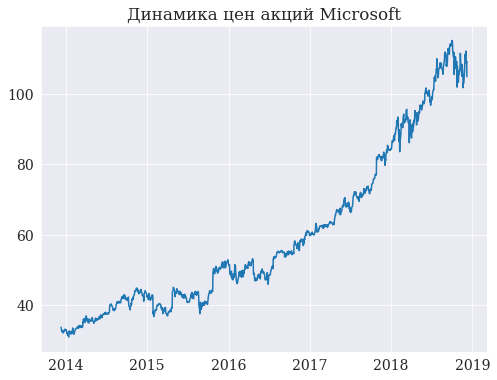

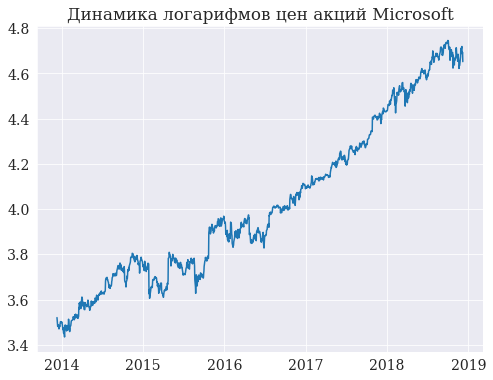

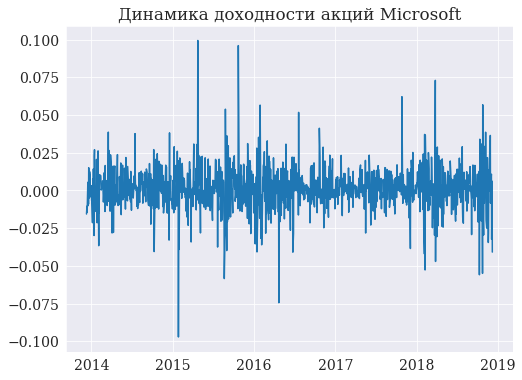

<Figure size 720x432 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(msft['Date'],msft['Adj Close'])
plt.title(u'Динамика цен акций Microsoft')

plt.figure(figsize=(8,6))
plt.plot(msft['Date'],np.log(msft['Adj Close']))
plt.title(u'Динамика логарифмов цен акций Microsoft')

plt.figure(figsize=(8,6))
plt.plot(msft['Date'],msft['Log_ret_MSFT'])
plt.title(u'Динамика доходности акций Microsoft')
plt.show()
plt.gcf().clear()

### 1. Проверка временного ряда на стационарность ($\alpha=0.05$)

 Модель авторегрессии - скользящего среднего корректно применять только к стационарным временным рядам. Стандартным критерием, используемым для проверки временного ряда на стационарность, явяляется критерий  Дикей-Фуллера (ADF - augmented Dickey-Fuller). В основе критерия лежит проверка значимости коэффициентов авторегрессии. Для данного критерия существуют специальные таблицы.

Проведем исследование стационарности для логарифмов цен и логарифмической доходности. Нулевая гипотеза состоит в том, что  процесс носит нестационарный характер. Говоря математическим языком - корни характеристического уравнения авторегрессионной модели лежат вунтри единичного круга. 

In [ ]:
tsa.stattools.adfuller(np.log(msft['Adj Close']),maxlag=10)
### логарифмы цен

(-0.10399823306438749,
 0.9490388349652016,
 8,
 1249,
 {'1%': -3.4355964295197743,
  '10%': -2.5680035060041626,
  '5%': -2.863856825923603},
 -7059.134393996628)

In [ ]:
tsa.stattools.adfuller(msft['Log_ret_MSFT'],maxlag=10)
### логарифмическая доходность

(-15.04375166074735,
 9.510170284412283e-28,
 7,
 1250,
 {'1%': -3.435592223709696, '10%': -2.56800251776, '5%': -2.8638549702604803},
 -7061.125098359102)

В приведенных результатах работы теста важными являются первые два элемента: само значение критерия и p-value. В случае логарифмов цен гипотеза об отсутствии стационарности принимается. В случае логарифмической доходности - гипотеза отвергается. Это означает, что для построения модели авторгерссии - скользящего среднего необходимо взять первые разности логарифмов цен (что и есть логарифмическая доходность).

### Определение порядков авторегресии и скользящего среднего

Порядок процесса можно предварительно определить с помощью графиков авткорреляции и частной автокорреляция. Для этого построим указанные графики для стационарного процесса логарифмической доходности.

1. Значимые коэффициенты автокорреляции определяют порядок скользящего среднего
2. Значимые коэффициенты частной автокорреляции определяют порядок авторегрессии

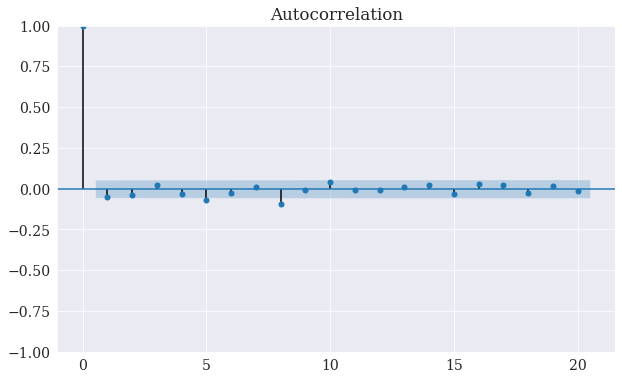

In [ ]:
fig=tsaplots.plot_acf(msft['Log_ret_MSFT'],lags=20)

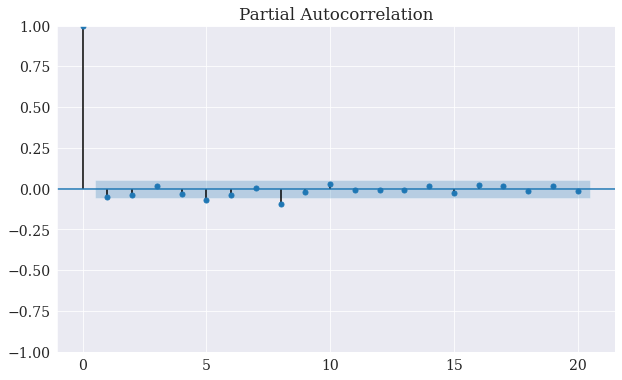

In [ ]:
fig=tsaplots.plot_pacf(msft['Log_ret_MSFT'],lags=20)

### 2. Построение модели ARIMA 

 В рассматриваемом случае нет возможности однозначно идентифицировать порядок модели только исходя из графиков. Обращает на себя внимание значимость коэффициентов для лаг 8. Реализуем простой цикл перебора параметров AR и MA.

In [ ]:
d=1 # порядок интеграции, берем первые разности
l=list()

Т.к. алгоритм расчета параметров модели может выдавать ошибку в случае несходимости, применем специальную конструкцию try - except, позволяющую обрабатывать исключения.

In [ ]:
import statsmodels.api as sm

for i in range(0,4):
    for j in range(0,4):
        flag=True
        print('ARIMA({},{},{})'.format(i,d,j))
        try:
            model=sm.tsa.ARIMA(np.log(msft['Adj Close']),order=(i,d,j))
            res=model.fit()
        except:
            flag=False                                                       
            pass
        if (flag):
            l.append((i,j,res.bic))

ARIMA(0,1,0)
ARIMA(0,1,1)
ARIMA(0,1,2)
ARIMA(0,1,3)
ARIMA(1,1,0)
ARIMA(1,1,1)
ARIMA(1,1,2)
ARIMA(1,1,3)
ARIMA(2,1,0)
ARIMA(2,1,1)
ARIMA(2,1,2)
ARIMA(2,1,3)
ARIMA(3,1,0)
ARIMA(3,1,1)
ARIMA(3,1,2)
ARIMA(3,1,3)


In [ ]:
l # первое число - порядок AR, второе число - порядок MA, третье число - BIC

[(0, 0, -7100.521881933352),
 (0, 1, -7096.4979618008),
 (0, 2, -7090.805939413908),
 (0, 3, -7084.0526806456555),
 (1, 0, -7096.282520128261),
 (1, 1, -7090.110813370134),
 (1, 2, -7083.534233515591),
 (1, 3, -7076.557979327235),
 (2, 0, -7090.878931523851),
 (2, 1, -7084.293042318371),
 (2, 2, -7076.105146311727),
 (2, 3, -7073.1328777881945),
 (3, 0, -7084.30241563925),
 (3, 1, -7077.126516341772),
 (3, 2, -7069.984500505839),
 (3, 3, -7062.772753343759),
 (0, 0, -7100.521881933352),
 (0, 1, -7096.4979618008),
 (0, 2, -7090.805939413908),
 (0, 3, -7084.0526806456555),
 (1, 0, -7096.282520128261),
 (1, 1, -7090.110813370134),
 (1, 2, -7083.534233515591),
 (1, 3, -7076.557979327235),
 (2, 0, -7090.878931523851),
 (2, 1, -7084.293042318371),
 (2, 2, -7076.105146311727),
 (2, 3, -7073.1328777881945),
 (3, 0, -7084.30241563925),
 (3, 1, -7077.126516341772),
 (3, 2, -7069.984500505839),
 (3, 3, -7062.772753343759)]

 Для целей задания ограничимся самой простой моделью порядка (1,1,1), т.е. моделью авторегрессии первого порядка и скользящего среднего первого порядка, построенную по первым разностям.

$\Delta y_t=\phi_0+\phi_1\Delta y_{t-1}+\varepsilon_t-\theta_1\varepsilon_{t-1}$

In [ ]:
model_1=sm.tsa.ARIMA(np.log(msft['Adj Close']),order=(1,1,1))

In [ ]:
results_1=model_1.fit()

In [ ]:
print(results_1.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1258
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3555.760
Date:                Sun, 19 Jun 2022   AIC                          -7105.520
Time:                        19:01:34   BIC                          -7090.111
Sample:                             0   HQIC                         -7099.729
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2336      0.392      0.597      0.551      -0.534       1.001
ma.L1         -0.2840      0.387     -0.734      0.463      -1.042       0.474
sigma2         0.0002    3.8e-06     53.790      0.0

Остатки модели ARIMA должны быть процессом "белого шума" (отсутствует автокорреляция)

Для проверки гипотезы, связанной с присутствием в остатках автокорреляции будем использовать тест Льюнга-Бокса. Данный тест  основан на  коэффициентах автокорреляции, рассчитываемых для разного количества лагов (смещений). Таким образом данный тест позволяет идентифицировать автокорреляцию остатков более высоких порядков.

In [ ]:
test.acorr_ljungbox(results_1.resid)
### значение статистики и pvalue Льюнга-Бокса

,lb_stat,lb_pvalue
1,0.020645,0.885750
2,0.040067,0.980166
3,0.061348,0.996032
4,0.061434,0.999538
5,0.087844,0.999882
6,0.088362,0.999986
7,0.097734,0.999998
8,0.102303,1.000000
9,0.105838,1.000000
10,0.126553,1.000000


Общий вывод: Модель ARIMA (1,1,1), в целом, адекватно описывает исследуемый процесс. Коэффиценты AR  и MA меньше 1. Это говорит о том, что процесс имеет характер  "возврата к средней" (mean reversion). В частности, на основе данного процесса можно строить "статистические" арбитражные стратегии торговли. В противном случае речь идет о взрывной динамике, и процессом сложно управлять.

###  3. Построение модели GARCH

Процесс GARCH строится на основе остатков модели ARIMA, т.е. отфильтрованных данных. Для идентификации кластеров волатильности используются графики квадрата остатков и ACF для квадрата остатков.

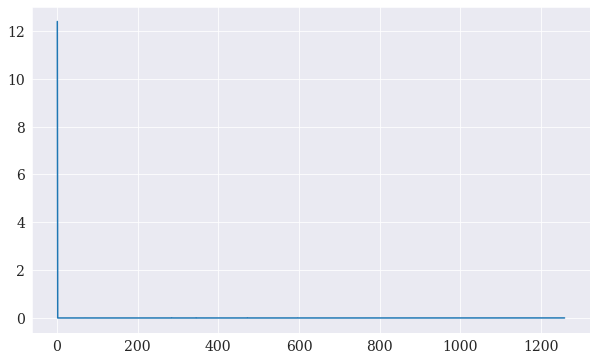

In [ ]:
fig=(results_1.resid**2).plot()

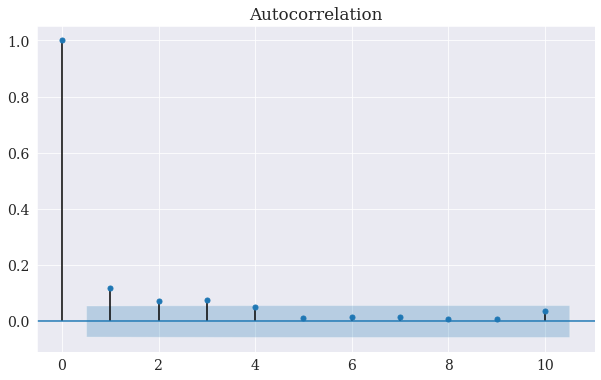

In [ ]:
fig=tsaplots.plot_acf(results_1.resid**2,lags=10)

С помощью  теста Льюнга-Бокса проверим ряд квадратов остатков на наличие автокорреляции.

In [ ]:
test.acorr_ljungbox(results_1.resid**2).iloc[0:10, 1]
###  pvalue статистики Льюнга-Бокса

1     0.999926
2     1.000000
3     1.000000
4     1.000000
5     1.000000
6     1.000000
7     1.000000
8     1.000000
9     1.000000
10    1.000000
Name: lb_pvalue, dtype: float64

Значение теста показывает, что в ряде квадрата остатков присутствует автокорреляция, следовательно в исследовани необходимо использовать модель GARCH.

Для построения модели воспользуемся библиотекой ARCH. Построим модель GARCH по двум наборам данных - по исходным данным и по остаткам модели ARIMA. Если в качестве объекта исследования рассматриваются исходные данные, необходимо первоначально построить модель доходности.

Ограничимся простой моделью GARCH(1,1), имеющий следующий вид:

$\varepsilon_t=\sigma_t\epsilon_t$
${\sigma^2}_t=\omega+\alpha_1{\varepsilon^2}_{t-1}+\beta_1{\sigma^2}_{t-1}$

#### 3.1. Модель по исходным данным

Моделирование доходности - Zero Mean

In [ ]:
zm=ZeroMean(msft['Log_ret_MSFT'])

In [ ]:
zm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Zero Mean - Constant Variance Model Results                  
==============================================================================
Dep. Variable:           Log_ret_MSFT   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:          Constant Variance   Log-Likelihood:                3556.56
Distribution:                  Normal   AIC:                          -7111.12
Method:            Maximum Likelihood   BIC:                          -7105.99
                                        No. Observations:                 1258
Date:                Sun, Jun 19 2022   Df Residuals:                     1258
Time:                        19:10:19   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2     2.0506e-04  1.758e-05     11.666  1.908e-31 [1.706e-04,2.395e-04]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

In [ ]:
zm.volatility=GARCH(p=1,q=1)

In [ ]:
res_zm = zm.fit(update_freq=0, disp='off')

In [ ]:
res_zm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:           Log_ret_MSFT   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                3608.91
Distribution:                  Normal   AIC:                          -7211.82
Method:            Maximum Likelihood   BIC:                          -7196.41
                                        No. Observations:                 1258
Date:                Sun, Jun 19 2022   Df Residuals:                     1258
Time:                        19:10:31   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.4260e-05  4.543e-06      9.742  1.988e-22 [3.536e-05,5.316e-05]
alpha[1]       0.1642  5.658e-02      2.902  3.706e-03   [5.331e-02,  0.275]
beta[1]        0.6432  4.183e-02     15.376  2.376e-53     [  0.561,  0.725]
============================================================================

Covariance estimator: robust
"""

Модель не дает в полной мере адекватного результата, т.к. отсутсвует сходимость алгоритма.

##### Моделирование доходности - Constant Mean

$r_t=\mu+\varepsilon_t$

In [ ]:
cm=ConstantMean(msft['Log_ret_MSFT'])

In [ ]:
cm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Constant Mean - Constant Variance Model Results                
==============================================================================
Dep. Variable:           Log_ret_MSFT   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:          Constant Variance   Log-Likelihood:                3558.98
Distribution:                  Normal   AIC:                          -7113.96
Method:            Maximum Likelihood   BIC:                          -7103.69
                                        No. Observations:                 1258
Date:                Sun, Jun 19 2022   Df Residuals:                     1257
Time:                        19:14:24   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.8739e-04  4.030e-04      2.202  2.766e-02 [9.759e-05,1.677e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2     2.0428e-04  1.754e-05     11.649  2.318e-31 [1.699e-04,2.386e-04]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

In [ ]:
cm.volatility=GARCH(p=1,q=1)

In [ ]:
res_cm = cm.fit(update_freq=0, disp='off')

In [ ]:
res_cm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:           Log_ret_MSFT   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3615.65
Distribution:                  Normal   AIC:                          -7223.30
Method:            Maximum Likelihood   BIC:                          -7202.75
                                        No. Observations:                 1258
Date:                Sun, Jun 19 2022   Df Residuals:                     1257
Time:                        19:15:06   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.1121e-03  3.493e-04      3.183  1.456e-03 [4.274e-04,1.797e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.6560e-05  3.306e-06     11.059  1.972e-28 [3.008e-05,4.304e-05]
alpha[1]       0.2159  8.189e-02      2.636  8.393e-03   [5.535e-02,  0.376]
beta[1]        0.6357  5.411e-02     11.748  7.243e-32     [  0.530,  0.742]
============================================================================

Covariance estimator: robust
"""

 Проверим остатки модели на наличие автокорреляции

In [ ]:
test.acorr_ljungbox(res_cm.resid)[0:10]
### значение и pvalue статистики Льюнга-Бокса

,lb_stat,lb_pvalue
1,3.307514,0.068964
2,5.147825,0.076237
3,5.729123,0.125559
4,7.031543,0.134231
5,12.982473,0.023544
6,13.954911,0.030144
7,14.169999,0.048239
8,25.147152,0.001468
9,25.207227,0.002750
10,27.632603,0.002066


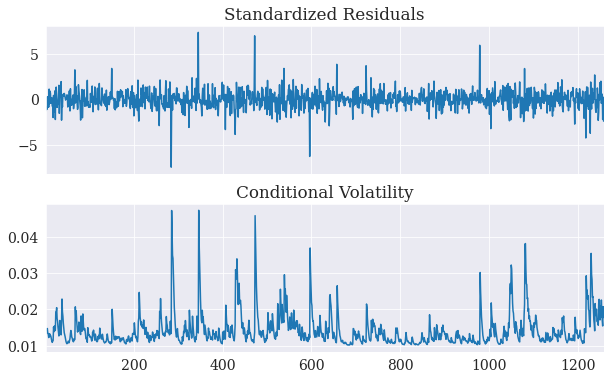

In [ ]:
fig=res_cm.plot()

 В первых лагах автокорреляция отсутсвует, однако  для более отдаленных лагов можно  отметить наличие внутренней зависимости. По этой причине однозначного вывода об адекватности модели сделать нельзя.

##### Моделирование доходности - AR

In [ ]:
ar=ARX(msft['Log_ret_MSFT'],lags=[1]) # моделирование доходности с помощью процесса AR(1)

In [ ]:
ar.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     AR - Constant Variance Model Results                     
==============================================================================
Dep. Variable:           Log_ret_MSFT   R-squared:                       0.003
Mean Model:                        AR   Adj. R-squared:                  0.002
Vol Model:          Constant Variance   Log-Likelihood:                3557.98
Distribution:                  Normal   AIC:                          -7109.97
Method:            Maximum Likelihood   BIC:                          -7094.56
                                        No. Observations:                 1257
Date:                Sun, Jun 19 2022   Df Residuals:                     1255
Time:                        19:17:14   Df Model:                            2
                                   Mean Model                                  
===============================================================================
                    coef    std err          t      P>|t|      95.0% Conf. Int.
-------------------------------------------------------------------------------
Const         9.4800e-04  4.089e-04      2.318  2.042e-02 [1.466e-04,1.749e-03]
Log_...SFT[1]    -0.0516  4.076e-02     -1.265      0.206   [ -0.131,2.832e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2     2.0368e-04  1.758e-05     11.584  4.985e-31 [1.692e-04,2.381e-04]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

In [ ]:
ar.volatility=GARCH(p=1,q=1)

In [ ]:
res_ar = ar.fit(update_freq=0, disp='off')

In [ ]:
res_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:           Log_ret_MSFT   R-squared:                       0.002
Mean Model:                        AR   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                3613.30
Distribution:                  Normal   AIC:                          -7216.60
Method:            Maximum Likelihood   BIC:                          -7190.91
                                        No. Observations:                 1257
Date:                Sun, Jun 19 2022   Df Residuals:                     1255
Time:                        19:17:19   Df Model:                            2
                                   Mean Model                                  
===============================================================================
                    coef    std err          t      P>|t|      95.0% Conf. Int.
-------------------------------------------------------------------------------
Const         1.1358e-03  3.569e-04      3.182  1.462e-03 [4.362e-04,1.835e-03]
Log_...SFT[1]    -0.0225  4.902e-02     -0.459      0.646   [ -0.119,7.357e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.6370e-05  3.214e-06     11.315  1.103e-29 [3.007e-05,4.267e-05]
alpha[1]       0.2103  8.600e-02      2.446  1.446e-02   [4.177e-02,  0.379]
beta[1]        0.6405  5.497e-02     11.652  2.248e-31     [  0.533,  0.748]
============================================================================

Covariance estimator: robust
"""

#####  Проверим остатки модели на наличие автокорреляции

In [ ]:
test.acorr_ljungbox(res_ar.resid.dropna())[0:10]
###  pvalue статистики Льюнга-Бокса

,lb_stat,lb_pvalue
1,1.191980,0.274931
2,3.181947,0.203727
3,3.628613,0.304461
4,5.001623,0.287131
5,11.347945,0.044901
6,12.416852,0.053290
7,12.539232,0.084163
8,23.333785,0.002961
9,23.420254,0.005318
10,25.903015,0.003873


 В первых лагах автокорреляция отсутсвует, однако  для более отдаленных лагов можно  отметить наличие внутренней зависимости. По этой причине однозначного вывода об адекватности модели сделать нельзя.

##### Расчет безусловной волатильности и устойчивости (persistence) возмущения

In [ ]:
res_cm.params

mu          0.001112
omega       0.000037
alpha[1]    0.215851
beta[1]     0.635674
Name: params, dtype: float64

In [ ]:
res_cm.params[1]/(1-res_cm.params[2]-res_cm.params[3]) 

0.00024623697334556945

In [ ]:
res_cm.params[2]+res_cm.params[3]

0.8515245164167151

#### 3.2. Модель по остаткам ARIMA 

In [ ]:
cm_1=ConstantMean(results_1.resid) # модель постоянной средней

In [ ]:
cm_1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Constant Mean - Constant Variance Model Results                
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:          Constant Variance   Log-Likelihood:                1109.06
Distribution:                  Normal   AIC:                          -2214.11
Method:            Maximum Likelihood   BIC:                          -2203.84
                                        No. Observations:                 1258
Date:                Sun, Jun 19 2022   Df Residuals:                     1257
Time:                        19:24:54   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.7638e-03  2.825e-03      1.332      0.183 [-1.773e-03,9.301e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
sigma2         0.0100  9.826e-03      1.022      0.307 [-9.217e-03,2.930e-02]
=============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

In [ ]:
cm_1.volatility=GARCH(p=1,q=1)

In [ ]:
res_cm_1 = cm_1.fit(update_freq=0, disp='off')

In [ ]:
res_cm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                936.937
Distribution:                  Normal   AIC:                          -1865.87
Method:            Maximum Likelihood   BIC:                          -1845.32
                                        No. Observations:                 1258
Date:                Sun, Jun 19 2022   Df Residuals:                     1257
Time:                        19:24:56   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -9.0402e-03  7.389e-03     -1.223      0.221 [-2.352e-02,5.443e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0241  1.177e-04    204.340      0.000 [2.383e-02,2.429e-02]
alpha[1]       0.6018      0.952      0.632      0.527     [ -1.264,  2.467]
beta[1]        0.2982  1.693e-02     17.608  2.121e-69     [  0.265,  0.331]
============================================================================

Covariance estimator: robust
"""

In [ ]:
test.acorr_ljungbox(res_cm_1.resid)[0:10]
###  pvalue статистики Льюнга-Бокса

,lb_stat,lb_pvalue
1,0.020645,0.885750
2,0.040067,0.980166
3,0.061348,0.996032
4,0.061434,0.999538
5,0.087844,0.999882
6,0.088362,0.999986
7,0.097734,0.999998
8,0.102303,1.000000
9,0.105838,1.000000
10,0.126553,1.000000


 Можно сделать вывод об отсутствии автокорреляции остатков модели GARCH.
 
Общий вывод - модель ARIMA-GARCH может быть использована для моделирования рассматриваемого временного ряда.

## 3.Нахождение рыночной β и тестирование гипотезы CAPM

Классическая версия модели CAPM предполагает отсутсвие в регрессионной модели свободного члена или в инвестиционной терминологии $\alpha$.  Это означает, что рассматриваемый актив не может систематически "обыграть" рынок. Таким образом, основной акцент делается на показателе рыночной $\beta$.

$ER_i=R_f+\beta_i(ER_m-R_f)$

### Модель CAPM на основе индекса SP500 (дневные данные)

In [ ]:
sp=pd.read_csv('https://github.com/qununc/UFR/raw/main/no2_time_series/%5EGSPC.csv')
# загрузка данных по динамике индекса SP500 

In [ ]:
sp['Date']=pd.to_datetime(sp['Date'],format='%Y-%m-%d')
###  преобразование поля в формат даты

In [ ]:
sp['Log_ret_SP']=np.log(sp['Adj Close'])-np.log(sp['Adj Close'].shift(1))
### расчет логарифмической доходности

In [ ]:
sp.drop([0],axis=0,inplace=True)
### удаление первого наблюдения со значением nan

In [ ]:
port=sp[['Date','Log_ret_SP']].merge(msft[['Date','Log_ret_MSFT']],left_on=['Date'],right_on=['Date'])
### объединение акций и индекса в один dataframe

In [ ]:
port.columns=['Date','Log_ret_SP','Log_ret_MSFT']

In [ ]:
port.tail()

,Date,Log_ret_SP,Log_ret_MSFT
1253,2018-11-30,0.008138,0.006333
1254,2018-12-03,0.010882,0.010763
1255,2018-12-04,-0.032900,-0.032368
1256,2018-12-06,-0.001523,0.006155
1257,2018-12-07,-0.023596,-0.040845


In [ ]:
results_3=smf.ols('Log_ret_MSFT ~ Log_ret_SP',data=port).fit()
### простая линейная регрессия

In [ ]:
print(results_3.summary())

                            OLS Regression Results                            
Dep. Variable:           Log_ret_MSFT   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     1314.
Date:                Sun, 19 Jun 2022   Prob (F-statistic):          1.61e-197
Time:                        19:27:59   Log-Likelihood:                 4009.4
No. Observations:                1258   AIC:                            -8015.
Df Residuals:                    1256   BIC:                            -8004.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.000      1.814      0.0

Проверка выполнения условия гомоскедастичности с помощью критерия Бреуша-Пагана

In [ ]:
lm,lm_value,fvalue,f_pvalue=diagnostic.het_breuschpagan(results_3.resid,results_3.model.exog)
print('lm %.4f,lm_pvalue %.4f,fvalue %.4f,f_pvalue %.4f'%(lm,lm_value,fvalue,f_pvalue))

lm 0.0565,lm_pvalue 0.8121,fvalue 0.0564,f_pvalue 0.8123


С учетом значения p-value гипотеза об отсутствии гомоскедастичности принимается

#### Проверка наличия структурных сдвигов

Структурный сдвиг означает, что процесс притерпевает определенные изменения, которые могут сильно сказаться на параметрах модели. В случае наличия структурного сдвга целесооборазно использовать не одну, а две модели - до сдвига и после. Проверка гипотезы об отсутствии структурных сдвигов осуществвляется с помощью ряда  критериев, самым популярным из которых в эконометрике остается тест Чоу. В statsmodels реализованы критерий кумулятивной суммы (CUSUM)  и критерий Хансена. 

In [ ]:
diagnostic.breaks_cusumolsresid(results_3.resid)[0:2]

(0.7417390915141887, 0.6410867229055668)

In [ ]:
diagnostic.breaks_hansen(results_3)[0:2]

(2.4095495981471986, array([( 2, 1.9 ), ( 6, 3.75), (15, 3.75), (19, 4.52)],
       dtype=[('nobs', '<i8'), ('crit', '<f8')]))

С учетом значения критериев и p-value гипотеза об отсутствии структурного сдвига принимается

**Общие выводы:**
1. Уравнение значимо, что подтверждается t и F критериями.
2. Показатель $\beta$ = 1.26, это говорит о том, что акции Microsoft растут (и, соответственно, падают) сильнее рынка акций, включающего все отрасли.
3. Показатель $\alpha$ статистчически незначимо отличается от 0, что согласуется с моделью CAPM

### Модель CAPM на основе индекса NASDAQ (дневные данные)

In [ ]:
nasdaq = pd.read_csv('https://github.com/qununc/UFR/raw/main/no2_time_series/%5EIXIC.csv')

In [ ]:
nasdaq['Date']=pd.to_datetime(nasdaq['Date'],format='%Y-%m-%d')
###  преобразование поля в формат даты

In [ ]:
nasdaq['Log_ret_Nasdaq']=np.log(nasdaq['Adj Close'])-np.log(nasdaq['Adj Close'].shift(1))

In [ ]:
nasdaq.drop([0],axis=0,inplace=True)

In [ ]:
nasdaq.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Log_ret_Nasdaq
1,2013-12-12,4004.750000,4013.540039,3993.570068,3998.399902,3998.399902,1893270000,-0.001352
2,2013-12-13,4015.530029,4017.449951,3992.290039,4000.979980,4000.979980,1615340000,0.000645
3,2013-12-16,4019.370117,4043.000000,4019.139893,4029.520020,4029.520020,1943830000,0.007108
4,2013-12-17,4028.879883,4034.689941,4011.580078,4023.679932,4023.679932,1861130000,-0.001450
5,2013-12-18,4024.669922,4070.379883,3979.590088,4070.060059,4070.060059,2178330000,0.011461


In [ ]:
port=port.merge(nasdaq[['Date','Log_ret_Nasdaq']],left_on=['Date'],right_on=['Date'])

In [ ]:
port.head()

,Date,Log_ret_SP,Log_ret_MSFT,Log_ret_Nasdaq
0,2013-12-12,-0.003778,-0.010424,-0.001352
1,2013-12-13,-0.000101,-0.014342,0.000645
2,2013-12-16,0.006300,0.005437,0.007108
3,2013-12-17,-0.003106,-0.010081,-0.001450
4,2013-12-18,0.016511,0.001642,0.011461


In [ ]:
results_4=smf.ols('Log_ret_MSFT ~ Log_ret_Nasdaq',data=port).fit()
### простая линейная регрессия

In [ ]:
print(results_4.summary())

                            OLS Regression Results                            
Dep. Variable:           Log_ret_MSFT   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     1643.
Date:                Sun, 19 Jun 2022   Prob (F-statistic):          2.87e-230
Time:                        19:34:11   Log-Likelihood:                 4079.3
No. Observations:                1256   AIC:                            -8155.
Df Residuals:                    1254   BIC:                            -8144.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0004      0.000      1.

**Общие выводы:**
1. Уравнение значимо, что подтверждается t и F критериями.
2. Показатель $\beta$ = 1.10, это говорит о том, что акции Microsoft растут (и, соответственно, падают) быстрее рынка технологических акций. 
3. Показатель $\alpha$ статистчически незначимо отличается от 0, что согласуется с моделью CAPM

### Модель CAPM на основе индекса SP500 (месячные данные)

In [ ]:
port['Year']=port['Date'].dt.year

In [ ]:
port['Month']=port['Date'].dt.month

Для преобразования дневных доходностей в месячные доходности воспользуемся удобным свойством логарифма и просуммируем дневные доходности по каждому месяцу

In [ ]:
port_monthly=port.groupby(['Year','Month'])[['Log_ret_SP','Log_ret_MSFT','Log_ret_Nasdaq']].sum()
### преобразование дневных доходностей в месячные доходности

In [ ]:
port_monthly.head()

Log_ret_SP  Log_ret_MSFT  Log_ret_Nasdaq
Year Month                                          
2013 12       0.036439     -0.005332        0.042249
2014 1       -0.036231      0.011429       -0.017562
     2        0.042213      0.019815        0.048569
     3        0.006908      0.067617       -0.025658
     4        0.006182     -0.014498       -0.020312

In [ ]:
np.log(float(msft[msft.Date=='2014-01-31']['Adj Close'])/float(msft[msft.Date=='2013-12-31']['Adj Close']))
### проверка формулы получения месячной доходности

0.011428544757738605

In [ ]:
results_5=smf.ols('Log_ret_MSFT ~ Log_ret_SP',data=port_monthly).fit()
### простая линейная регрессия

In [ ]:
print(results_5.summary())

                            OLS Regression Results                            
Dep. Variable:           Log_ret_MSFT   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     38.48
Date:                Sun, 19 Jun 2022   Prob (F-statistic):           5.94e-08
Time:                        19:35:44   Log-Likelihood:                 103.46
No. Observations:                  61   AIC:                            -202.9
Df Residuals:                      59   BIC:                            -198.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0109      0.006      1.850      0.0

Выводы аналогичны предыдущим моделям

# Домашнее задание

1. Выбрать актив и загрузить из внешних источников исторические котировки(например, Yahoo finance)
2. Провести предварительный анализ временного ряда , проверить гипотезу стационарности
3. Построить модель ARIMA-GARCH и сделать краткие выводы
4. Построить модель CAPM по рыночным данным, получить $\beta$, оценить значимость $\alpha$, сравнить полученный показатель $\beta$ с данными из общедоступных источников информации (например, Yahoo, Reuters)

## 2.Исследование временного ряда

Для моделирования временного ряда используется подход Бокса-Дженкенса, состоящий из следующих основных этапов:
1. Проверка стационарности ряда временного ряда
2. Приведение временного ряда к стационарному виду  (взятие первых и т.д. разностей)
3. Построение модели ARIMA
4. Проверка остатков модели ARIMA на отсутствие автокорреляции
5. Проверка отсутствия автокорреляции в отношении квадратов остатков модели ARIMA
6. Построение модели GARCH

In [8]:
import datetime
import yfinance as yf

In [9]:
# Input Start and End Date
start = datetime.datetime(2013,12,1)
end = datetime.datetime(2018,12,1)
stock_final = yf.download(['AMD'],start=start, end=end, progress=False, show_errors=False).loc[:, ['Adj Close', 'Volume']]

stock_result = stock_final.drop(['Volume'], axis=1).reset_index()
stock_result['Date'] = pd.to_datetime(stock_result['Date'], infer_datetime_format=True)
amd = stock_result.drop_duplicates(ignore_index=True)


In [10]:
amd.head()

,Date,Adj Close
0,2013-12-02,3.66
1,2013-12-03,3.62
2,2013-12-04,3.57
3,2013-12-05,3.64
4,2013-12-06,3.66


In [11]:
amd.dtypes

Date         datetime64[ns]
Adj Close           float64
dtype: object

Переход от цен к логарифмическим доходностям

$ln(\frac{p_{i+1}}{p_{i}})=ln(p_{i+1})-ln(p_i)$ 

In [12]:
amd['Log_ret_AMD']=np.log(amd['Adj Close'])-np.log(amd['Adj Close'].shift(1))
# расчет логарифмической доходности

In [13]:
amd.head()

,Date,Adj Close,Log_ret_AMD
0,2013-12-02,3.66,NaN
1,2013-12-03,3.62,-0.010989
2,2013-12-04,3.57,-0.013908
3,2013-12-05,3.64,0.019418
4,2013-12-06,3.66,0.005479


In [14]:
amd.drop([0],axis=0,inplace=True)
# удаление первого наблюдения nan

In [15]:
amd['Log_ret_AMD'].describe()
#основные характеристики динамического ряда логарифмической доходности

count    1259.000000
mean        0.001399
std         0.037776
min        -0.277456
25%        -0.016138
50%         0.000494
75%         0.018288
max         0.420617
Name: Log_ret_AMD, dtype: float64

In [16]:
np.var(amd['Log_ret_AMD'])
# дисперсия ряда                                                             

0.001425874976622092

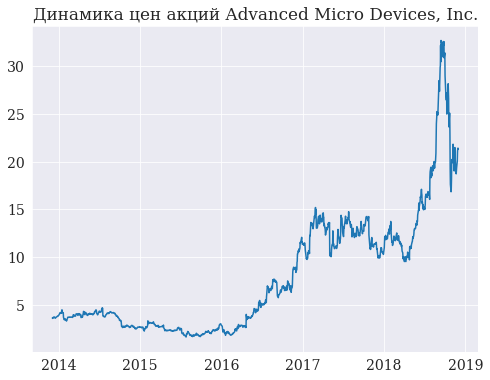

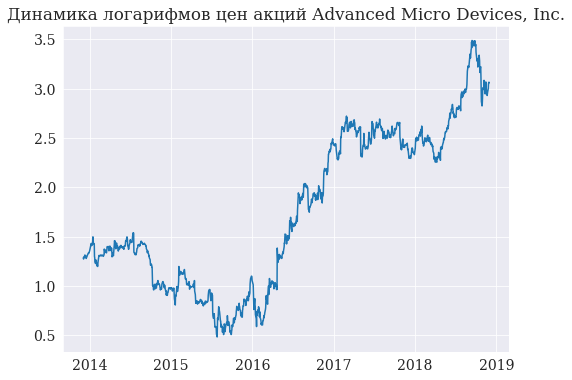

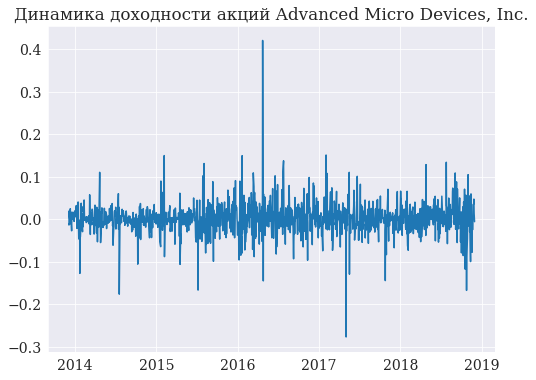

<Figure size 720x432 with 0 Axes>

In [17]:
plt.figure(figsize=(8,6))
plt.plot(amd['Date'],amd['Adj Close'])
plt.title(u'Динамика цен акций Advanced Micro Devices, Inc.')

plt.figure(figsize=(8,6))
plt.plot(amd['Date'],np.log(amd['Adj Close']))
plt.title(u'Динамика логарифмов цен акций Advanced Micro Devices, Inc.')

plt.figure(figsize=(8,6))
plt.plot(amd['Date'],amd['Log_ret_AMD'])
plt.title(u'Динамика доходности акций Advanced Micro Devices, Inc.')
plt.show()
plt.gcf().clear()

### 1. Проверка временного ряда на стационарность ($\alpha=0.05$)

 Модель авторегрессии - скользящего среднего корректно применять только к стационарным временным рядам. Стандартным критерием, используемым для проверки временного ряда на стационарность, явяляется критерий  Дикей-Фуллера (ADF - augmented Dickey-Fuller). В основе критерия лежит проверка значимости коэффициентов авторегрессии. Для данного критерия существуют специальные таблицы.

Проведем исследование стационарности для логарифмов цен и логарифмической доходности. Нулевая гипотеза состоит в том, что  процесс носит нестационарный характер. Говоря математическим языком - корни характеристического уравнения авторегрессионной модели лежат вунтри единичного круга. 

In [18]:
tsa.stattools.adfuller(np.log(amd['Adj Close']),maxlag=10)
### логарифмы цен

(-0.26351542768294256,
 0.9305150460722125,
 2,
 1256,
 {'1%': -3.4355671297788666,
  '10%': -2.5679966213893057,
  '5%': -2.8638438984080117},
 -4625.993544138789)

In [19]:
tsa.stattools.adfuller(amd['Log_ret_AMD'],maxlag=10)
### логарифмическая доходность

(-23.349492188738736,
 0.0,
 1,
 1257,
 {'1%': -3.4355629707955395,
  '10%': -2.567995644141416,
  '5%': -2.863842063387667},
 -4627.921991783481)

В приведенных результатах работы теста важными являются первые два элемента: само значение критерия и p-value. В случае логарифмов цен гипотеза об отсутствии стационарности принимается. В случае логарифмической доходности - гипотеза отвергается. Это означает, что для построения модели авторгерссии - скользящего среднего необходимо взять первые разности логарифмов цен (что и есть логарифмическая доходность).

### Определение порядков авторегресии и скользящего среднего

Порядок процесса можно предварительно определить с помощью графиков авткорреляции и частной автокорреляция. Для этого построим указанные графики для стационарного процесса логарифмической доходности.

1. Значимые коэффициенты автокорреляции определяют порядок скользящего среднего
2. Значимые коэффициенты частной автокорреляции определяют порядок авторегрессии

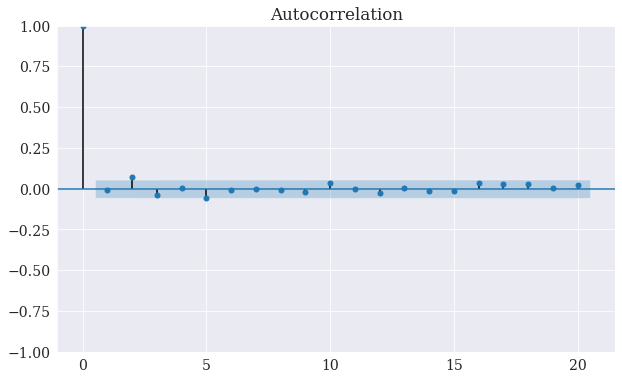

In [20]:
fig=tsaplots.plot_acf(amd['Log_ret_AMD'],lags=20)

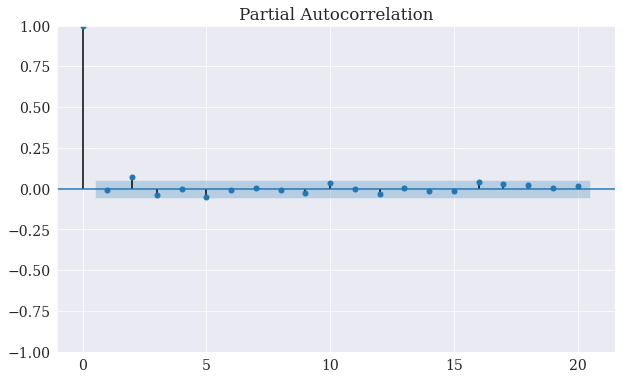

In [21]:
fig=tsaplots.plot_pacf(amd['Log_ret_AMD'],lags=20)

### 2. Построение модели ARIMA 

 В рассматриваемом случае нет возможности однозначно идентифицировать порядок модели только исходя из графиков. Реализуем простой цикл перебора параметров AR и MA.

In [22]:
d=1 # порядок интеграции, берем первые разности
l=list()

Т.к. алгоритм расчета параметров модели может выдавать ошибку в случае несходимости, применем специальную конструкцию try - except, позволяющую обрабатывать исключения.

In [23]:
import statsmodels.api as sm

for i in range(0,4):
    for j in range(0,4):
        flag=True
        print('ARIMA({},{},{})'.format(i,d,j))
        try:
            model=sm.tsa.ARIMA(np.log(amd['Adj Close']),order=(i,d,j))
            res=model.fit()
        except:
            flag=False                                                       
            pass
        if (flag):
            l.append((i,j,res.bic))

ARIMA(0,1,0)
ARIMA(0,1,1)
ARIMA(0,1,2)
ARIMA(0,1,3)
ARIMA(1,1,0)
ARIMA(1,1,1)
ARIMA(1,1,2)
ARIMA(1,1,3)
ARIMA(2,1,0)
ARIMA(2,1,1)
ARIMA(2,1,2)
ARIMA(2,1,3)
ARIMA(3,1,0)
ARIMA(3,1,1)
ARIMA(3,1,2)
ARIMA(3,1,3)


In [24]:
l # первое число - порядок AR, второе число - порядок MA, третье число - BIC

[(0, 0, -4663.8086481108685),
 (0, 1, -4656.678738948603),
 (0, 2, -4656.385333704082),
 (0, 3, -4650.199765742721),
 (1, 0, -4656.689726430582),
 (1, 1, -4654.667889952944),
 (1, 2, -4650.854039814815),
 (1, 3, -4643.074272077037),
 (2, 0, -4656.441617784172),
 (2, 1, -4651.265123948143),
 (2, 2, -4644.009866745084),
 (2, 3, -4637.245774903002),
 (3, 0, -4650.834900454041),
 (3, 1, -4643.697593583236),
 (3, 2, -4637.145072272275),
 (3, 3, -4631.937982192887)]

 Для целей задания ограничимся самой простой моделью порядка (1,1,1), т.е. моделью авторегрессии первого порядка и скользящего среднего первого порядка, построенную по первым разностям.

$\Delta y_t=\phi_0+\phi_1\Delta y_{t-1}+\varepsilon_t-\theta_1\varepsilon_{t-1}$

In [25]:
model_1=sm.tsa.ARIMA(np.log(amd['Adj Close']),order=(1,1,1))

In [26]:
results_1=model_1.fit()

In [27]:
print(results_1.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1259
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2338.040
Date:                Sat, 25 Jun 2022   AIC                          -4670.080
Time:                        15:11:26   BIC                          -4654.668
Sample:                             0   HQIC                         -4664.288
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8702      0.118     -7.392      0.000      -1.101      -0.639
ma.L1          0.8388      0.127      6.580      0.000       0.589       1.089
sigma2         0.0014   2.02e-05     70.431      0.0

Остатки модели ARIMA должны быть процессом "белого шума" (отсутствует автокорреляция)

Для проверки гипотезы, связанной с присутствием в остатках автокорреляции будем использовать тест Льюнга-Бокса. Данный тест  основан на  коэффициентах автокорреляции, рассчитываемых для разного количества лагов (смещений). Таким образом данный тест позволяет идентифицировать автокорреляцию остатков более высоких порядков.

In [28]:
test.acorr_ljungbox(results_1.resid)
### значение статистики и pvalue Льюнга-Бокса

,lb_stat,lb_pvalue
1,0.135330,0.712968
2,1.215234,0.544647
3,1.230656,0.745661
4,1.486550,0.829021
5,1.647080,0.895498
6,2.062985,0.913816
7,2.136251,0.951916
8,2.297270,0.970515
9,2.673891,0.975836
10,3.106807,0.978798


Общий вывод: Модель ARIMA (1,1,1), в целом, адекватно описывает исследуемый процесс. Коэффиценты AR  и MA меньше 1. Это говорит о том, что процесс имеет характер  "возврата к средней" (mean reversion). В частности, на основе данного процесса можно строить "статистические" арбитражные стратегии торговли. В противном случае речь идет о взрывной динамике, и процессом сложно управлять.

###  3. Построение модели GARCH

Процесс GARCH строится на основе остатков модели ARIMA, т.е. отфильтрованных данных. Для идентификации кластеров волатильности используются графики квадрата остатков и ACF для квадрата остатков.

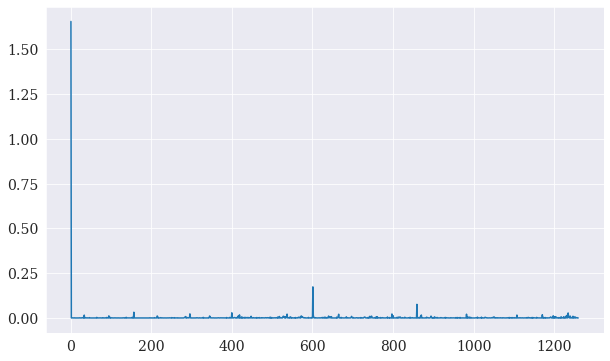

In [29]:
fig=(results_1.resid**2).plot()

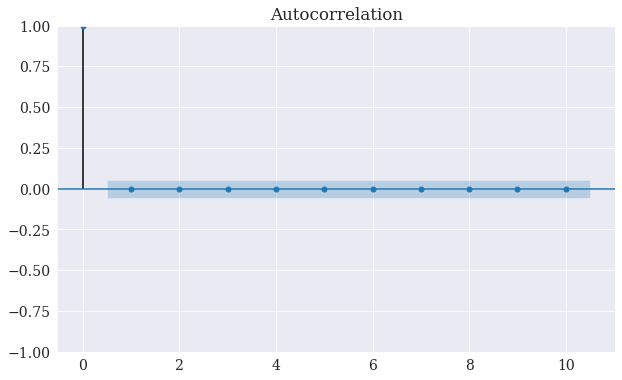

In [30]:
fig=tsaplots.plot_acf(results_1.resid**2,lags=10)

С помощью  теста Льюнга-Бокса проверим ряд квадратов остатков на наличие автокорреляции.

In [31]:
test.acorr_ljungbox(results_1.resid**2).iloc[0:10, 1]
###  pvalue статистики Льюнга-Бокса

1     0.979215
2     0.999427
3     0.999986
4     1.000000
5     1.000000
6     1.000000
7     1.000000
8     1.000000
9     1.000000
10    1.000000
Name: lb_pvalue, dtype: float64

Значение теста показывает, что в ряде квадрата остатков присутствует автокорреляция, следовательно в исследовани необходимо использовать модель GARCH.

Для построения модели воспользуемся библиотекой ARCH. Построим модель GARCH по двум наборам данных - по исходным данным и по остаткам модели ARIMA. Если в качестве объекта исследования рассматриваются исходные данные, необходимо первоначально построить модель доходности.

Ограничимся простой моделью GARCH(1,1), имеющий следующий вид:

$\varepsilon_t=\sigma_t\epsilon_t$
${\sigma^2}_t=\omega+\alpha_1{\varepsilon^2}_{t-1}+\beta_1{\sigma^2}_{t-1}$

#### 3.1. Модель по исходным данным

Моделирование доходности - Zero Mean

In [32]:
zm=ZeroMean(amd['Log_ret_AMD'])

In [33]:
zm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Zero Mean - Constant Variance Model Results                  
==============================================================================
Dep. Variable:            Log_ret_AMD   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:          Constant Variance   Log-Likelihood:                2337.79
Distribution:                  Normal   AIC:                          -4673.57
Method:            Maximum Likelihood   BIC:                          -4668.44
                                        No. Observations:                 1259
Date:                Sat, Jun 25 2022   Df Residuals:                     1259
Time:                        15:11:28   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2     1.4278e-03  1.723e-04      8.285  1.186e-16 [1.090e-03,1.766e-03]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

In [34]:
zm.volatility=GARCH(p=1,q=1)

In [35]:
res_zm = zm.fit(update_freq=0, disp='off')

In [36]:
res_zm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:            Log_ret_AMD   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                2381.78
Distribution:                  Normal   AIC:                          -4757.56
Method:            Maximum Likelihood   BIC:                          -4742.14
                                        No. Observations:                 1259
Date:                Sat, Jun 25 2022   Df Residuals:                     1259
Time:                        15:11:28   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.7780e-04  1.422e-04      2.656  7.901e-03 [9.904e-05,6.566e-04]
alpha[1]       0.3252      0.174      1.870  6.146e-02  [-1.561e-02,  0.666]
beta[1]        0.4932  7.897e-02      6.245  4.251e-10     [  0.338,  0.648]
============================================================================

Covariance estimator: robust
"""

Модель не дает в полной мере адекватного результата, т.к. отсутсвует сходимость алгоритма.

##### Моделирование доходности - Constant Mean

$r_t=\mu+\varepsilon_t$

In [37]:
cm=ConstantMean(amd['Log_ret_AMD'])

In [38]:
cm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Constant Mean - Constant Variance Model Results                
==============================================================================
Dep. Variable:            Log_ret_AMD   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:          Constant Variance   Log-Likelihood:                2338.65
Distribution:                  Normal   AIC:                          -4673.30
Method:            Maximum Likelihood   BIC:                          -4663.03
                                        No. Observations:                 1259
Date:                Sat, Jun 25 2022   Df Residuals:                     1258
Time:                        15:11:28   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.3989e-03  1.064e-03      1.315      0.189 [-6.869e-04,3.485e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2     1.4259e-03  1.718e-04      8.298  1.060e-16 [1.089e-03,1.763e-03]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

In [39]:
cm.volatility=GARCH(p=1,q=1)

In [40]:
res_cm = cm.fit(update_freq=0, disp='off')

In [41]:
res_cm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:            Log_ret_AMD   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2386.04
Distribution:                  Normal   AIC:                          -4764.07
Method:            Maximum Likelihood   BIC:                          -4743.52
                                        No. Observations:                 1259
Date:                Sat, Jun 25 2022   Df Residuals:                     1258
Time:                        15:11:28   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.7557e-03  1.636e-03      1.684  9.217e-02 [-4.515e-04,5.963e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.7012e-04  1.454e-04      2.546  1.091e-02 [8.516e-05,6.551e-04]
alpha[1]       0.3631      0.215      1.690  9.094e-02  [-5.788e-02,  0.784]
beta[1]        0.4760  8.102e-02      5.875  4.234e-09     [  0.317,  0.635]
============================================================================

Covariance estimator: robust
"""

 Проверим остатки модели на наличие автокорреляции

In [42]:
test.acorr_ljungbox(res_cm.resid)[0:10]
### значение и pvalue статистики Льюнга-Бокса

,lb_stat,lb_pvalue
1,0.033174,0.855474
2,6.679491,0.035446
3,8.382166,0.038740
4,8.401862,0.077918
5,12.536524,0.028132
6,12.625353,0.049387
7,12.626417,0.081751
8,12.703566,0.122464
9,13.332132,0.148144
10,14.752106,0.141364


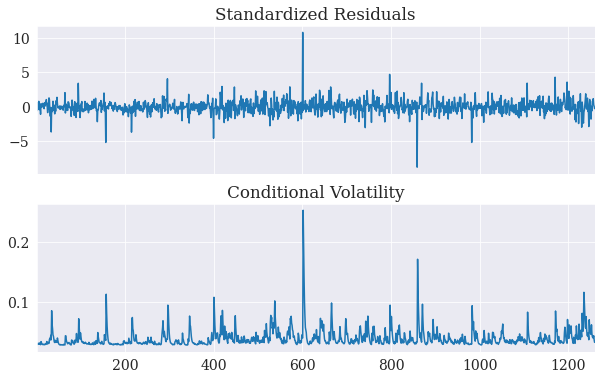

In [43]:
fig=res_cm.plot()

Можно  отметить наличие внутренней зависимости. По этой причине однозначного вывода об адекватности модели сделать нельзя.

##### Моделирование доходности - AR

In [44]:
ar=ARX(amd['Log_ret_AMD'],lags=[1]) # моделирование доходности с помощью процесса AR(1)

In [45]:
ar.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     AR - Constant Variance Model Results                     
==============================================================================
Dep. Variable:            Log_ret_AMD   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                 -0.001
Vol Model:          Constant Variance   Log-Likelihood:                2336.36
Distribution:                  Normal   AIC:                          -4666.73
Method:            Maximum Likelihood   BIC:                          -4651.32
                                        No. Observations:                 1258
Date:                Sat, Jun 25 2022   Df Residuals:                     1256
Time:                        15:11:30   Df Model:                            2
                                    Mean Model                                   
=================================================================================
                     coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------------
Const          1.4160e-03  1.066e-03      1.329      0.184 [-6.724e-04,3.504e-03]
Log_...AMD[1] -5.1273e-03  4.811e-02     -0.107      0.915 [-9.941e-02,8.916e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2     1.4268e-03  1.718e-04      8.303  1.014e-16 [1.090e-03,1.764e-03]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

In [46]:
ar.volatility=GARCH(p=1,q=1)

In [47]:
res_ar = ar.fit(update_freq=0, disp='off')

In [48]:
res_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:            Log_ret_AMD   R-squared:                      -0.015
Mean Model:                        AR   Adj. R-squared:                 -0.016
Vol Model:                      GARCH   Log-Likelihood:                2388.18
Distribution:                  Normal   AIC:                          -4766.37
Method:            Maximum Likelihood   BIC:                          -4740.68
                                        No. Observations:                 1258
Date:                Sat, Jun 25 2022   Df Residuals:                     1256
Time:                        15:11:30   Df Model:                            2
                                   Mean Model                                   
================================================================================
                    coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------------------------
Const         2.5398e-03  1.329e-03      1.912  5.592e-02 [-6.421e-05,5.144e-03]
Log_...AMD[1]     0.1135  8.876e-02      1.278      0.201   [-6.050e-02,  0.287]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.4474e-04  1.315e-04      2.622  8.741e-03 [8.704e-05,6.024e-04]
alpha[1]       0.4148      0.259      1.603      0.109  [-9.222e-02,  0.922]
beta[1]        0.4646  8.140e-02      5.708  1.143e-08     [  0.305,  0.624]
============================================================================

Covariance estimator: robust
"""

#####  Проверим остатки модели на наличие автокорреляции

In [49]:
test.acorr_ljungbox(res_ar.resid.dropna())[0:10]
###  pvalue статистики Льюнга-Бокса

,lb_stat,lb_pvalue
1,19.777513,0.000009
2,27.314317,0.000001
3,29.896054,0.000001
4,30.156554,0.000005
5,34.186359,0.000002
6,34.191341,0.000006
7,34.192428,0.000016
8,34.226885,0.000037
9,35.036074,0.000059
10,36.695334,0.000064


Можно  отметить наличие внутренней зависимости. По этой причине однозначного вывода об адекватности модели сделать нельзя.

##### Расчет безусловной волатильности и устойчивости (persistence) возмущения

In [50]:
res_cm.params

mu          0.002756
omega       0.000370
alpha[1]    0.363094
beta[1]     0.475985
Name: params, dtype: float64

In [51]:
res_cm.params[1]/(1-res_cm.params[2]-res_cm.params[3]) 

0.0023000105108733244

In [52]:
res_cm.params[2]+res_cm.params[3]

0.8390788087135852

#### 3.2. Модель по остаткам ARIMA 

In [53]:
cm_1=ConstantMean(results_1.resid) # модель постоянной средней

In [54]:
cm_1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Constant Mean - Constant Variance Model Results                
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:          Constant Variance   Log-Likelihood:                1929.68
Distribution:                  Normal   AIC:                          -3855.36
Method:            Maximum Likelihood   BIC:                          -3845.08
                                        No. Observations:                 1259
Date:                Sat, Jun 25 2022   Df Residuals:                     1258
Time:                        15:11:31   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.4540e-03  1.473e-03      1.666  9.565e-02 [-4.324e-04,5.340e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2     2.7304e-03  1.319e-03      2.070  3.841e-02 [1.457e-04,5.315e-03]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

In [55]:
cm_1.volatility=GARCH(p=1,q=1)

In [56]:
res_cm_1 = cm_1.fit(update_freq=0, disp='off')

In [57]:
res_cm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2326.68
Distribution:                  Normal   AIC:                          -4645.35
Method:            Maximum Likelihood   BIC:                          -4624.80
                                        No. Observations:                 1259
Date:                Sat, Jun 25 2022   Df Residuals:                     1258
Time:                        15:11:31   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.2486e-03  1.054e-03      2.133  3.294e-02 [1.822e-04,4.315e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.7304e-04  1.145e-04      2.385  1.706e-02 [4.870e-05,4.974e-04]
alpha[1]       0.2000      0.221      0.906      0.365     [ -0.233,  0.633]
beta[1]        0.7000      0.121      5.798  6.725e-09     [  0.463,  0.937]
============================================================================

Covariance estimator: robust
"""

In [58]:
test.acorr_ljungbox(res_cm_1.resid)[0:10]
###  pvalue статистики Льюнга-Бокса

,lb_stat,lb_pvalue
1,0.135330,0.712968
2,1.215234,0.544647
3,1.230656,0.745661
4,1.486550,0.829021
5,1.647080,0.895498
6,2.062985,0.913816
7,2.136251,0.951916
8,2.297270,0.970515
9,2.673891,0.975836
10,3.106807,0.978798


 Можно сделать вывод об отсутствии автокорреляции остатков модели GARCH.
 
Общий вывод - модель ARIMA-GARCH может быть использована для моделирования рассматриваемого временного ряда.

## 3.Нахождение рыночной β и тестирование гипотезы CAPM

Классическая версия модели CAPM предполагает отсутсвие в регрессионной модели свободного члена или в инвестиционной терминологии $\alpha$.  Это означает, что рассматриваемый актив не может систематически "обыграть" рынок. Таким образом, основной акцент делается на показателе рыночной $\beta$.

$ER_i=R_f+\beta_i(ER_m-R_f)$

### Модель CAPM на основе индекса SP500 (дневные данные)

In [59]:
sp=pd.read_csv('https://github.com/qununc/UFR/raw/main/no2_time_series/%5EGSPC.csv')
# загрузка данных по динамике индекса SP500 

In [60]:
sp['Date']=pd.to_datetime(sp['Date'],format='%Y-%m-%d')
###  преобразование поля в формат даты

In [61]:
sp['Log_ret_SP']=np.log(sp['Adj Close'])-np.log(sp['Adj Close'].shift(1))
### расчет логарифмической доходности

In [62]:
sp.drop([0],axis=0,inplace=True)
### удаление первого наблюдения со значением nan

In [63]:
port=sp[['Date','Log_ret_SP']].merge(amd[['Date','Log_ret_AMD']],left_on=['Date'],right_on=['Date'])
### объединение акций и индекса в один dataframe

In [64]:
port.columns=['Date','Log_ret_SP','Log_ret_AMD']

In [65]:
port.tail()

,Date,Log_ret_SP,Log_ret_AMD
1249,2018-11-26,0.015413,0.035483
1250,2018-11-27,0.003256,0.047176
1251,2018-11-28,0.022714,0.013683
1252,2018-11-29,-0.002185,0.004209
1253,2018-11-30,0.008138,-0.006085


In [66]:
results_3=smf.ols('Log_ret_AMD ~ Log_ret_SP',data=port).fit()
### простая линейная регрессия

In [67]:
print(results_3.summary())

                            OLS Regression Results                            
Dep. Variable:            Log_ret_AMD   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     154.2
Date:                Sat, 25 Jun 2022   Prob (F-statistic):           1.77e-33
Time:                        15:11:32   Log-Likelihood:                 2400.0
No. Observations:                1254   AIC:                            -4796.
Df Residuals:                    1252   BIC:                            -4786.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0009      0.001      0.878      0.3

Проверка выполнения условия гомоскедастичности с помощью критерия Бреуша-Пагана

In [68]:
lm,lm_value,fvalue,f_pvalue=diagnostic.het_breuschpagan(results_3.resid,results_3.model.exog)
print('lm %.4f,lm_pvalue %.4f,fvalue %.4f,f_pvalue %.4f'%(lm,lm_value,fvalue,f_pvalue))

lm 0.1227,lm_pvalue 0.7261,fvalue 0.1225,f_pvalue 0.7264


С учетом значения p-value гипотеза об отсутствии гомоскедастичности принимается

#### Проверка наличия структурных сдвигов

Структурный сдвиг означает, что процесс притерпевает определенные изменения, которые могут сильно сказаться на параметрах модели. В случае наличия структурного сдвга целесооборазно использовать не одну, а две модели - до сдвига и после. Проверка гипотезы об отсутствии структурных сдвигов осуществвляется с помощью ряда  критериев, самым популярным из которых в эконометрике остается тест Чоу. В statsmodels реализованы критерий кумулятивной суммы (CUSUM)  и критерий Хансена. 

In [69]:
diagnostic.breaks_cusumolsresid(results_3.resid)[0:2]

(1.090080052256537, 0.1855922571347565)

In [70]:
diagnostic.breaks_hansen(results_3)[0:2]

(0.9404890216960894, array([( 2, 1.9 ), ( 6, 3.75), (15, 3.75), (19, 4.52)],
       dtype=[('nobs', '<i8'), ('crit', '<f8')]))

С учетом значения критериев и p-value гипотеза об отсутствии структурного сдвига принимается

**Общие выводы:**
1. Уравнение значимо, что подтверждается t и F критериями.
2. Показатель $\beta$ = 1.56, это говорит о том, что акции Advanced Micro Devices, Inc. растут (и, соответственно, падают) сильнее рынка акций, включающего все отрасли.
3. Показатель $\alpha$ статистчически незначимо отличается от 0, что согласуется с моделью CAPM

### Модель CAPM на основе индекса NASDAQ (дневные данные)

In [71]:
nasdaq = pd.read_csv('https://github.com/qununc/UFR/raw/main/no2_time_series/%5EIXIC.csv')

In [72]:
nasdaq['Date']=pd.to_datetime(nasdaq['Date'],format='%Y-%m-%d')
###  преобразование поля в формат даты

In [73]:
nasdaq['Log_ret_Nasdaq']=np.log(nasdaq['Adj Close'])-np.log(nasdaq['Adj Close'].shift(1))

In [74]:
nasdaq.drop([0],axis=0,inplace=True)

In [75]:
nasdaq.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Log_ret_Nasdaq
1,2013-12-12,4004.750000,4013.540039,3993.570068,3998.399902,3998.399902,1893270000,-0.001352
2,2013-12-13,4015.530029,4017.449951,3992.290039,4000.979980,4000.979980,1615340000,0.000645
3,2013-12-16,4019.370117,4043.000000,4019.139893,4029.520020,4029.520020,1943830000,0.007108
4,2013-12-17,4028.879883,4034.689941,4011.580078,4023.679932,4023.679932,1861130000,-0.001450
5,2013-12-18,4024.669922,4070.379883,3979.590088,4070.060059,4070.060059,2178330000,0.011461


In [76]:
port=port.merge(nasdaq[['Date','Log_ret_Nasdaq']],left_on=['Date'],right_on=['Date'])

In [77]:
port.head()

,Date,Log_ret_SP,Log_ret_AMD,Log_ret_Nasdaq
0,2013-12-12,-0.003778,0.002714,-0.001352
1,2013-12-13,-0.000101,0.000000,0.000645
2,2013-12-16,0.006300,-0.027474,0.007108
3,2013-12-17,-0.003106,0.016575,-0.001450
4,2013-12-18,0.016511,0.000000,0.011461


In [78]:
results_4=smf.ols('Log_ret_AMD ~ Log_ret_Nasdaq',data=port).fit()
### простая линейная регрессия

In [79]:
print(results_4.summary())

                            OLS Regression Results                            
Dep. Variable:            Log_ret_AMD   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     181.2
Date:                Sat, 25 Jun 2022   Prob (F-statistic):           1.11e-38
Time:                        15:11:32   Log-Likelihood:                 2407.4
No. Observations:                1252   AIC:                            -4811.
Df Residuals:                    1250   BIC:                            -4801.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0007      0.001      0.

**Общие выводы:**
1. Уравнение значимо, что подтверждается t и F критериями.
2. Показатель $\beta$ = 1.39, это говорит о том, что акции Advanced Micro Devices, Inc. растут (и, соответственно, падают) быстрее рынка технологических акций. 
3. Показатель $\alpha$ статистчически незначимо отличается от 0, что согласуется с моделью CAPM

### Модель CAPM на основе индекса SP500 (месячные данные)

In [80]:
port['Year']=port['Date'].dt.year

In [81]:
port['Month']=port['Date'].dt.month

Для преобразования дневных доходностей в месячные доходности воспользуемся удобным свойством логарифма и просуммируем дневные доходности по каждому месяцу

In [82]:
port_monthly=port.groupby(['Year','Month'])[['Log_ret_SP','Log_ret_AMD','Log_ret_Nasdaq']].sum()
### преобразование дневных доходностей в месячные доходности

In [83]:
port_monthly.head()

Log_ret_SP  Log_ret_AMD  Log_ret_Nasdaq
Year Month                                         
2013 12       0.036439     0.050342        0.042249
2014 1       -0.036231    -0.120694       -0.017562
     2        0.042213     0.078472        0.048569
     3        0.006908     0.077759       -0.025658
     4        0.006182     0.019754       -0.020312

In [84]:
np.log(float(amd[amd.Date=='2014-01-31']['Adj Close'])/float(amd[amd.Date=='2013-12-31']['Adj Close']))
### проверка формулы получения месячной доходности

-0.12069419682980383

In [85]:
results_5=smf.ols('Log_ret_AMD ~ Log_ret_SP',data=port_monthly).fit()
### простая линейная регрессия

In [86]:
print(results_5.summary())

                            OLS Regression Results                            
Dep. Variable:            Log_ret_AMD   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     36.29
Date:                Sat, 25 Jun 2022   Prob (F-statistic):           1.24e-07
Time:                        15:11:33   Log-Likelihood:                 36.684
No. Observations:                  60   AIC:                            -69.37
Df Residuals:                      58   BIC:                            -65.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0029      0.018      0.161      0.8

Выводы аналогичны предыдущим моделям